In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP
using ImageFiltering

In [3]:
using BAT 

# High `p` Population: 

In [4]:
function smooth_hist(hst)
    edg = hst.edges[1]
    vls = hst.weights
    krn = KernelFactors.gaussian(6)
    vls_1 = deepcopy(vls)
    vls_1[50:end] .= imfilter(vls[50:end], krn)
    non_zero_min = unique(sort(vls_1))[2]
    vls_1 = replace(x-> iszero(x) ? non_zero_min : x, vls_1)
    vls_1 = vls_1 ./ sum(vls_1)
    return Histogram(edg, vls_1)
end
    

smooth_hist (generic function with 1 method)

In [5]:
background_hist_2 = load("../../data/experiment/dataset_2/m2/background.jld2")

conv_matrices = (
    cam_1 = smooth_hist(background_hist_2["cam_1"]),
    cam_2 = smooth_hist(background_hist_2["cam_2"]),
    cam_3 = smooth_hist(background_hist_2["cam_3"]),
    cam_4 = smooth_hist(background_hist_2["cam_4"]), 
);

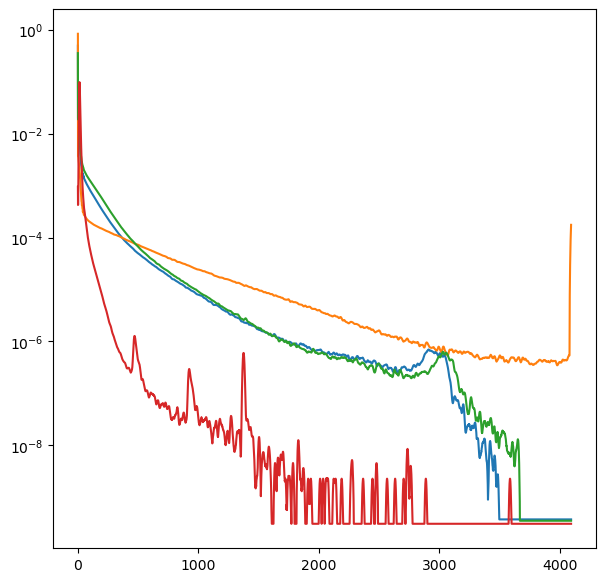

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.plot(conv_matrices.cam_1.weights)
ax.plot(conv_matrices.cam_2.weights)
ax.plot(conv_matrices.cam_3.weights)
ax.plot(conv_matrices.cam_4.weights)

ax.set_yscale("log")

# ax.set_xlim(0,30)
# ax.set_ylim(0,0.08)

In [7]:
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


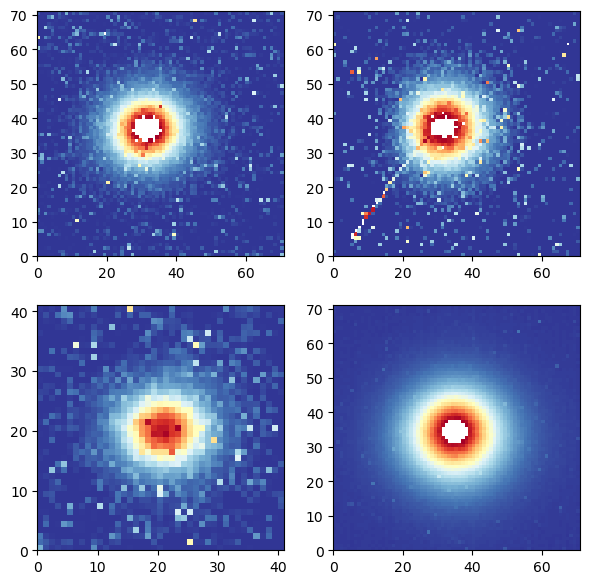

PyObject <matplotlib.collections.QuadMesh object at 0x7fd457160c70>

In [8]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [ ]:
background_hist_2 = load("../../data/experiment/dataset_2/m2/background.jld2")

In [ ]:
hist_b = background_hist_2["cam_1"]
edges = hist_b.edges[1]
background_values = hist_b.weights

kern_background = KernelFactors.gaussian(5)
background_values_smr = imfilter(background_values, kern_background)

background_values_smr[1:50] .=  background_values[1:50]

# hist_new = Histogram(edges, background_values_smr)

# background_values_smr = background_values_smr ./ sum(background_values_smr)

α = 2; int = 500

# signal_vals = cdf.(Normal(int, α*sqrt(int)), edges)
# signal_vals = diff(signal_vals)

signal_vals = pdf.(Normal(int, α*sqrt(int)), edges) ; signal_vals = signal_vals / sum(signal_vals);

# signal_conv = DSP.conv(signal_vals, background_values_smr)[1:4096]
# signal_conv = signal_conv .- minimum(signal_conv)

In [ ]:
# sum(signal_conv)

In [ ]:
# plt.plot(log.(background_values))
# plt.plot(log.(background_values_smr))
# plt.plot(log.(signal_conv))

In [ ]:
signal_conv = DSP.conv(signal_vals, background_values_smr)[1:4096]

# @benchmark DSP.conv(signal_vals[1:20], background_values_smr[1:20]) #[1:4096]

In [ ]:
function direct_conv(a::Array{T}, b::Array{T}) where {T <: AbstractFloat}
    m = length(a)
    n = length(b)
    c = zeros(T,m+n-1)
    @inbounds @simd for j=1:m
        @inbounds @simd for k=1:n
            c[j+k-1] += a[j]*b[k]
        end
    end
    return c
end

In [ ]:
j+k-1=4000

j = 4000 + 1 - k 

In [ ]:
signal_conv2 = direct_conv(signal_vals, background_values_smr)[1:4096]

# @benchmark direct_conv(signal_vals[1:20], background_values_smr[1:20]) #[1:4096]

In [ ]:
plt.plot(log.(abs.(signal_conv)))
plt.plot(log.(abs.(signal_conv2)))

plt.ylim(-60, 0)
# plt.xlim(0, 1000)

In [ ]:
ci = CartesianIndices(ones(2^12,2^12))
ci[[i.I[1]+i.I[2] == 5+1 for i in ci]]

In [ ]:
CartesianIndices(ones(5,5))[1]

### Mini-Problem: 

In [ ]:
background_hist_2 = load("../../data/experiment/dataset_2/m2/background.jld2")

hist_w = background_hist_2["cam_1"].weights
hist_edges = background_hist_2["cam_1"].edges[1]

kern_background = KernelFactors.gaussian(5)
hist_w_smr = deepcopy(hist_w)
hist_w_smr[50:end] = imfilter(hist_w[50:end], kern_background)
non_zero_min = unique(sort(hist_w_smr))[2]
hist_w_smr = replace(x-> iszero(x) ? non_zero_min : x, hist_w_smr)

α = 2; int = 15

# signal_vals2 = cdf.(Normal(int, α*sqrt(int)), hist_edges)
# signal_vals2 = diff(signal_vals2)

signal_vals = pdf.(Normal(int, α*sqrt(int)), hist_edges) ; signal_vals = signal_vals / sum(signal_vals);

In [ ]:
signal_conv_DSP = DSP.conv(signal_vals, hist_w_smr)[1:4096];

In [ ]:
signal_conv2 = direct_conv(signal_vals, hist_w_smr)[1:4096];

In [ ]:
dt = 23
dv = signal_conv2[dt]

In [ ]:
appval = 0.0
for k=1:dt
    j = dt + 1 - k
    appval += signal_vals[j]*hist_w_smr[k]
end
@show appval

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.plot(signal_vals)

# ax.plot(hist_w)
ax.plot(hist_w_smr)

ax.plot(signal_conv_DSP)
ax.plot(signal_conv2)

ax.scatter(dt - 1, dv, )

# ax.set_yscale("log")

ax.set_xlim(0,30)
ax.set_ylim(0,0.08)

In [9]:
# include("../src/likelihood.jl")
include("../../src/utill.jl")

corner_plots (generic function with 1 method)

In [30]:
function likelihood_cam4(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat}
   

    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    light_coefficient::VT = params.cam4_light_amp * 10^5
    
    δ_x::VT = params.cam4_psx * 10^-3
    δ_y::VT = params.cam4_psy * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2)
    @inbounds σ_y_1::VT = sqrt(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2)
    
    σ_x::VT = sqrt(σ_x_1^2 + (params.cam4_resx*δ_x)^2)
    σ_y::VT = sqrt(σ_y_1^2 + (params.cam4_resy*δ_y)^2)
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64) 
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

                right_tmp, left_tmp = pdf(Normal(μ_x,σ_x), x_edge), pdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(Normal(μ_y,σ_y), y_edge), pdf(Normal(μ_y,σ_y), y_edge - δ_y)
                pix_prediction *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y
                
                pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
                
#                 @inbounds cum_log_lik += logpdf(truncated(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), 0.0, 4096.0), image[pix_ind]) # leads to -Inf
                @inbounds cum_log_lik += logpdf(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), image[pix_ind]) # significantly speeds up auto diff
                
            end
        end
        
        @inbounds tot_loglik[t] = cum_log_lik
    end
    return sum(tot_loglik)
end


function likelihood_cam13(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        chist::Histogram,
        cfunc::Function, 
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat, C <: AbstractFloat}
    
    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    
    light_coefficient::VT = params.light_amp[cam_ind] * 10^5
    
    δ_x::VT = params.psx[cam_ind] * 10^-3
    δ_y::VT = params.psy[cam_ind] * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x::VT = sqrt(σ_x_1^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y::VT = sqrt(σ_y_1^2 + (params.resy[cam_ind]*δ_y)^2) # \sigma x is the same for both
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64)
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

                right_tmp, left_tmp = pdf(Normal(μ_x,σ_x), x_edge), pdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(Normal(μ_y,σ_y), y_edge), pdf(Normal(μ_y,σ_y), y_edge - δ_y)
                pix_prediction *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

                pix_prediction = pix_prediction*light_coefficient
                
                if pix_prediction > 6000.0
                    cumcv = 0.0
                elseif pix_prediction < 0.1 # can be replaced with larger 
                    obs_ind = convert(Integer, image[pix_ind]+1)
                    cumcv = chist.weights[obs_ind] 
                else 
                    
                    obs_ind = convert(Integer, image[pix_ind]+1) # index of signal
                    
                    # *** simple vector form (explodes memory allocations)
                    #   fluct_pr = pdf.(Normal(pix_prediction, params.light_fluct[cam_ind]*sqrt(pix_prediction)), collect(obs_ind:-1:0))
                    #   cumcv = sum((fluct_pr[2:end] .+ 0.5 .* (fluct_pr[1:end-1] .- fluct_pr[2:end])).*chist.weights[1:obs_ind] )

                    dist_fluct = Normal(pix_prediction, params.light_fluct[cam_ind]*sqrt(pix_prediction))
                    cumcv = 0.0
                    
#                     cumul_conv = zeros(n_threads)  
#                     Threads.@threads for t_conv in eachindex(cumul_conv)
#                         @inbounds for k in collect(1:obs_ind)[t_conv:n_threads:obs_ind]  # use threads? 
#                             j = obs_ind + 1 - k
#                             cvleft = pdf(dist_fluct, j - 1)
#                             cvright = pdf(dist_fluct, j)
#                             wtmp = cvleft + 0.5*(cvright - cvleft)
#                             cumul_conv[t_conv] += wtmp*chist.weights[k] 
#                         end
#                     end
#                     cumcv = sum(cumul_conv)
                    
                    cvright = pdf(dist_fluct, obs_ind)
                    cvleft = 0.0
                    @inbounds for k=1:obs_ind # use threads? 
                        j = obs_ind + 1 - k
                        cvleft = pdf(dist_fluct, j - 1)
                        wtmp = cvleft + 0.5*(cvright - cvleft)
                        cvright = cvleft
                        cumcv += wtmp*chist.weights[k] 
                    end
                    
                end
                
                @inbounds cum_log_lik += log(cumcv)
                
            end
        end
        tot_loglik[t] = cum_log_lik
        
    end
    return sum(tot_loglik)
end

likelihood_cam13 (generic function with 1 method)

In [31]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = x -> x,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik_ndiff()

#71 (generic function with 1 method)

In [32]:
v = (
    tr_size = [0.1425291216654245, 0.1306170428298254], 
    ang_spr = [3.9109811350414296, 4.922619501775121], 
    waist = [2.9450726745556017], 
    algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], 
    algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], 
    cam4_ped = 33.49172743923477, 
    cam4_light_fluct = 2.019998846685308, 
    cam4_light_amp = 8.38433943473823, 
    light_fluct = [5.0, 5.0, 5.0],
    resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], 
    resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], 
    cam4_resx = 6.229729394033021, 
    cam4_resy = 4.546125175291326, 
    psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], 
    psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], 
    cam4_psx = 121.9020704327851, 
    cam4_psy = 120.28319794460522, 
    light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], 
    s_cam = [0.0, 1.478, 15.026, 23.115]
);

In [33]:
log_likelihood(v)

LogDVal{Float64}(-73435.95665571246)

In [23]:
log_likelihood(v)

LogDVal{Float64}(-73435.95665571246)

In [ ]:
log_likelihood(v)

In [34]:
@benchmark log_likelihood(v)

BenchmarkTools.Trial: 
  memory estimate:  292.27 KiB
  allocs estimate:  223
  --------------
  minimum time:     12.952 ms (0.00% GC)
  median time:      15.113 ms (0.00% GC)
  mean time:        16.634 ms (0.00% GC)
  maximum time:     35.191 ms (0.00% GC)
  --------------
  samples:          301
  evals/sample:     1

In [35]:
# β = 0.015

β1 = 0.015
β2 = 0.008
β3 = 0.006

# flat prior for the pixel size
# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
#         waist = [Normal(2.9, 0.03)],
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 1.6 .. 9.9, 
#         light_fluct = [0.1 .. 2, 0.1 .. 2, 0.1 .. 2,],
#         resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#         cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
#         psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
#         psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
#         cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
#         cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
#         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     ); 

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.1, 0.25), truncated(Normal(0.2, 0.04), 0.1, 0.25)], 
    ang_spr = [3.9109811350414296, 4.922619501775121], 
    waist = [2.9450726745556017], 
    algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], 
    algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], 
    cam4_ped = 33.49172743923477, 
    cam4_light_fluct = 2.019998846685308, 
    cam4_light_amp = 8.38433943473823, 
    light_fluct = [0.5 .. 5, 0.5 .. 10, 0.5 .. 5,],
    resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], 
    resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], 
    cam4_resx = 6.229729394033021, 
    cam4_resy = 4.546125175291326, 
    psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], 
    psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], 
    cam4_psx = 121.9020704327851, 
    cam4_psy = 120.28319794460522, 
    light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], 
    s_cam = [0.0, 1.478, 15.026, 23.115]
);

In [36]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 150,
    max_nsteps_init = 150,
    max_time_init = 15
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 1000,
    max_nsteps_per_cycle = 1000,
    max_time_per_cycle = Inf,
    max_ncycles = 30
)

nsamples = 3*10^4
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [37]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = 50,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

3157.518733 seconds (104.59 M allocations: 36.406 GiB, 0.22% gc time)


In [38]:
samples = samples_tot.result;

In [39]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

3.9966444857849504

In [40]:
# light_fluct = [2.43941808354848, 4.3591830852627895, 1.896952479432151

In [41]:
size(flatview(unshaped.(samples.v)))

(5, 331)

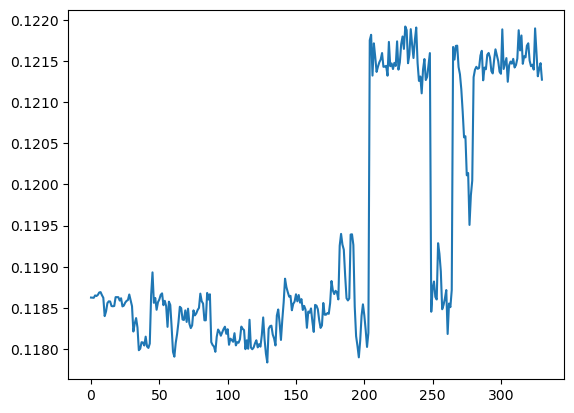

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd426fdd280>

In [42]:
plot(flatview(unshaped.(samples.v))[2,:])

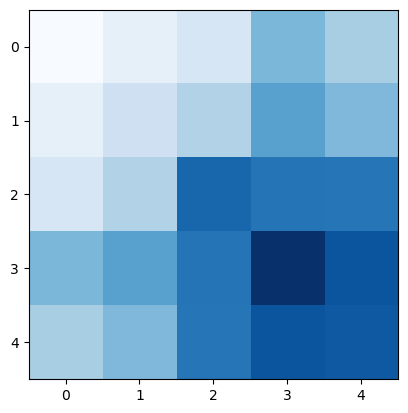

PyObject <matplotlib.image.AxesImage object at 0x7fd42cd5dfd0>

In [43]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [44]:
# BAT.bat_write("../data/sampling_results/MultipleEvents-2/mcmc-samples-1-3.hdf5", unshaped.(samples))

# BAT.bat_write("tmp.hdf5", unshaped.(samples))

In [45]:
mode(samples)[1]

(tr_size = [0.13420684389607193, 0.11808395359484321], ang_spr = [3.9109811350414296, 4.922619501775121], waist = [2.9450726745556017], algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], cam4_ped = 33.49172743923477, cam4_light_fluct = 2.019998846685308, cam4_light_amp = 8.38433943473823, light_fluct = [2.186933697222083, 4.4909471199100635, 1.7394166679627114], resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], cam4_resx = 6.229729394033021, cam4_resy = 4.546125175291326, psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], cam4_psx = 121.9020704327851, cam4_psy = 120.28319794460522, light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], s_cam = [0.0, 1.478, 15.026, 23.115])

In [46]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.134905, 0.11863], ang_spr = [3.9109811350414296, 4.922619501775121], waist = [2.9450726745556017], algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], cam4_ped = 33.49172743923477, cam4_light_fluct = 2.019998846685308, cam4_light_amp = 8.38433943473823, light_fluct = [2.151, 4.5275, 1.795], resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], cam4_resx = 6.229729394033021, cam4_resy = 4.546125175291326, psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], cam4_psx = 121.9020704327851, cam4_psy = 120.28319794460522, light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [47]:
mean(samples)[1]

(tr_size = [0.13441380004235695, 0.11922820192363882], ang_spr = [3.9109811350414296, 4.922619501775121], waist = [2.9450726745556017], algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], cam4_ped = 33.49172743923477, cam4_light_fluct = 2.019998846685308, cam4_light_amp = 8.38433943473823, light_fluct = [2.161300115964227, 4.515926152047388, 1.776854965267038], resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], cam4_resx = 6.229729394033021, cam4_resy = 4.546125175291326, psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], cam4_psx = 121.9020704327851, cam4_psy = 120.28319794460522, light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], s_cam = [0.0, 1.478, 15.026, 23.115])

In [48]:
std(samples)[1]

(tr_size = [0.0003807062889877367, 0.0014041096509400026], ang_spr = 2-element Fill{Float64}: entries equal to 0.0, waist = 1-element Fill{Float64}: entries equal to 0.0, algmx = 4-element Fill{Float64}: entries equal to 0.0, algmy = 4-element Fill{Float64}: entries equal to 0.0, cam4_ped = 0.0, cam4_light_fluct = 0.0, cam4_light_amp = 0.0, light_fluct = [0.04498999668121202, 0.15171024439794886, 0.061885914776591285], resx = 3-element Fill{Float64}: entries equal to 0.0, resy = 3-element Fill{Float64}: entries equal to 0.0, cam4_resx = 0.0, cam4_resy = 0.0, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = 3-element Fill{Float64}: entries equal to 0.0, s_cam = 4-element Fill{Float64}: entries equal to 0.0)

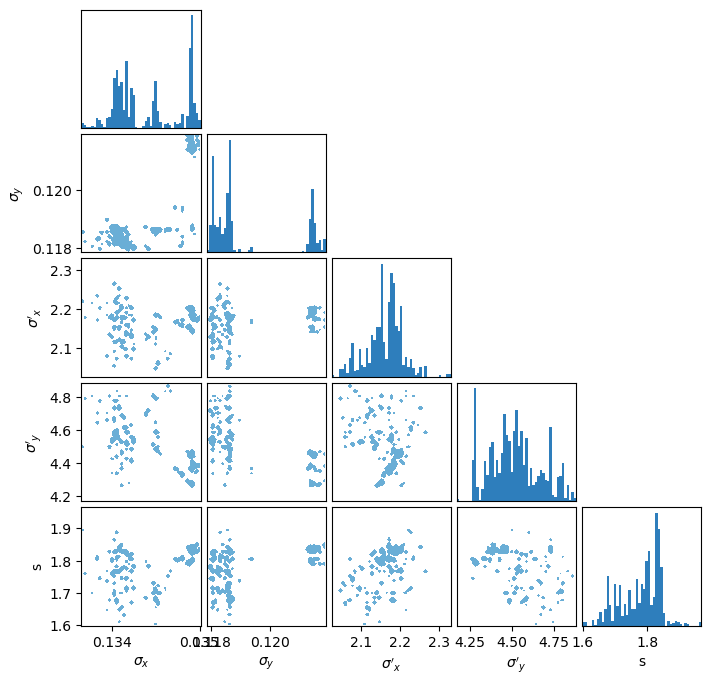

In [54]:
dims = [1,2,3,4,5]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
# levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.20,0.95,  1,]
figsize = (8,8)
n_bins = 50

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
β = 0.015

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
#         δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         is_ped = [29 .. 35],
#         is_light_f = [1.9 .. 2.3,],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


In [ ]:
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        is_ped = [29 .. 35],
        is_light_f = [1.9 .. 2.3,],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
mode(samples)[1]
 
#2.11452269382

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17,18,19,20,21]
names = dims
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22,23,]
names = dims
# levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_cam_integral([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [ ]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [3.07, 3.95, 2.13, 2.16],
        σ_y = [3.07 , 3.95, 2.13, 2.16], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [0, 0, 0, 0],
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [Normal(35147.44, β*35147.44), Normal(50235.06, β*50235.06), Normal(10096.64, β*10096.64), Normal(33406.9, β*33406.9)],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );



In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 120..220,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 200
);

algorithm = MetropolisHastings()

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# samples = bat_read("../data/sampling_results/Resolution_Effects/wc_resolution.hdf5") 
# samples = varshape(prior).(samples)
# # wcr_samples_uw = bat_sample(wcr_samples, length(wcr_samples)).result;

In [ ]:
# int = bat_integrate(samples)

In [ ]:
mode(samples)[1]

In [ ]:
bat_integrate(samples)

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wr_px_resolution.hdf5", unshaped.(samples))

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22, 23, 24, 25, 26, 27, 28, 29]
names = [22, 23, 24, 25, 26, 27, 28, 29]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
@show round.(unshaped(std(samples)), sigdigits=3)

In [ ]:
unshaped(std(samples))

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/w-34d-tmp_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean